# Set up Environment

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics.pairwise import cosine_similarity

import os
import argparse
import zipfile
import cv2

from collections import OrderedDict
from PIL import Image
import hashlib


import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version: ", sys.version)
print("Tensorflow Version: ", tf.__version__)

Python Version:  3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version:  2.4.0


### Set up for using GPU

In [5]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")



Using only GPU device /physical_device:GPU:0

GPU is available


### Load Model

In [6]:
model = tf.keras.models.load_model("./TrainingModels/flower_recommendation_model.h5")

### Model Construction

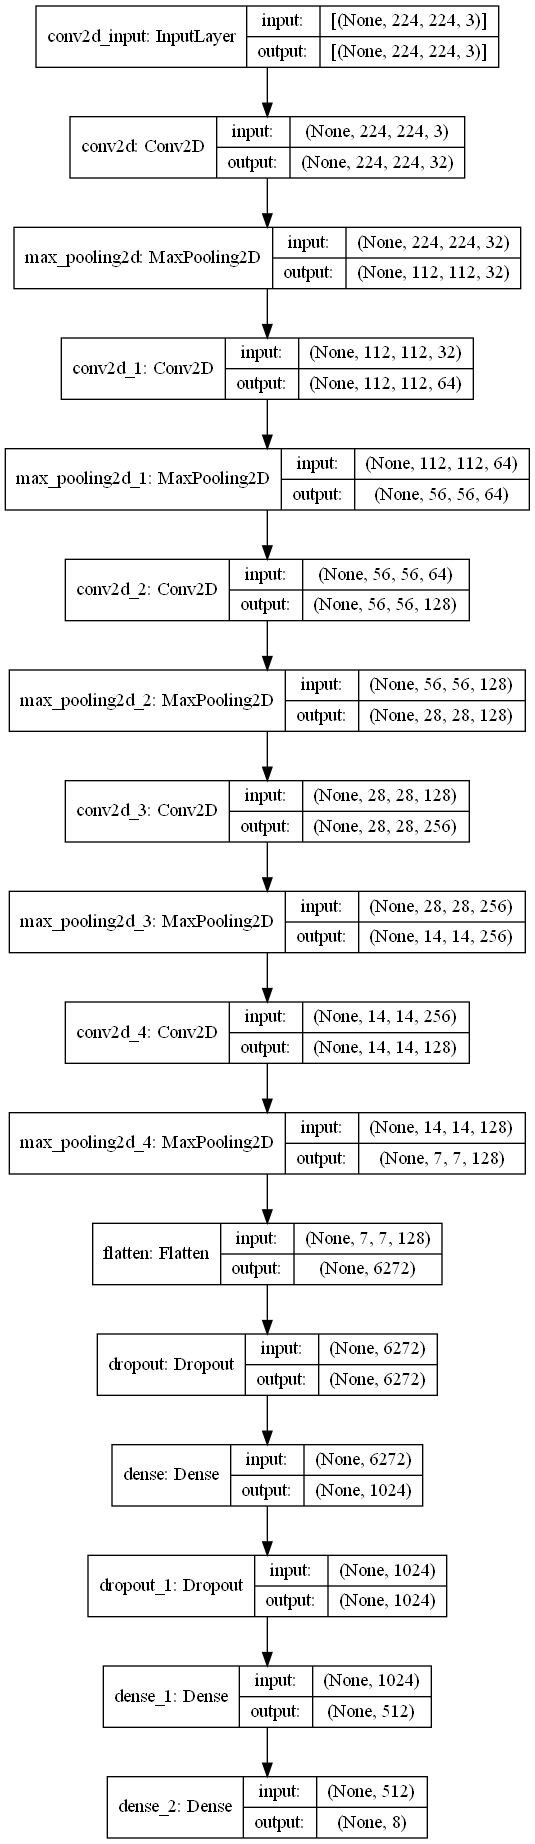

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


# Data Preparation For Both Dataset (Base and Addition Database for Testing in this task)

### Data Preparation Part 1 (Handle Base Dataset)

In [8]:
# unzip dataset file
path_to_zip_file = './Dataset/Flowers.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('./Dataset/')
    zip_ref.close()

path_to_zip_file = './Dataset/FlowersAdded.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('./Dataset/')
    zip_ref.close()

In [9]:
# get name of flower types (these will use as official categories)
base_dir = './Dataset/Flowers/'
dataset_categories = [f.name for f in os.scandir(base_dir) if f.is_dir()]
print(dataset_categories)

num_classes = len(dataset_categories)
print("Number of flower categories: " + str(num_classes))

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']
Number of flower categories: 8


In [10]:
# Set up path of image file
base_image_path=[]
base_flower=[]
for category in dataset_categories:
    dir_link = base_dir + category + "/"
    for img_path in os.listdir(dir_link):
        base_image_path.append(dir_link + img_path)
        base_flower.append(category)

Image_path = pd.Series(base_image_path, name="Image_Path").astype(str)
Image_path.head()

0      ./Dataset/Flowers/Babi/babi_1.jpg
1     ./Dataset/Flowers/Babi/babi_10.jpg
2    ./Dataset/Flowers/Babi/babi_100.jpg
3    ./Dataset/Flowers/Babi/babi_101.jpg
4    ./Dataset/Flowers/Babi/babi_102.jpg
Name: Image_Path, dtype: object

In [11]:
# Set up flower image categories and combine to get dataframe
Flowers=pd.Series(base_flower, name="Flower_Types")

base_dataset=pd.concat([Image_path, Flowers], axis=1)
base_dataset=base_dataset.sample(frac=1).reset_index(drop = True)


base_dataset.head(5)

,Image_Path,Flower_Types
0,./Dataset/Flowers/Chrysanthemum/chrysanthemum_...,Chrysanthemum
1,./Dataset/Flowers/Hydrangeas/hydrangeas_516.jpg,Hydrangeas
2,./Dataset/Flowers/Lisianthus/lisianthus_215.jpg,Lisianthus
3,./Dataset/Flowers/Tana/tana_381.jpg,Tana
4,./Dataset/Flowers/Lisianthus/lisianthus_512.jpg,Lisianthus


Exploration Data Analysis (EDA)

In [12]:
base_dataset.shape

(4621, 2)

<AxesSubplot:>

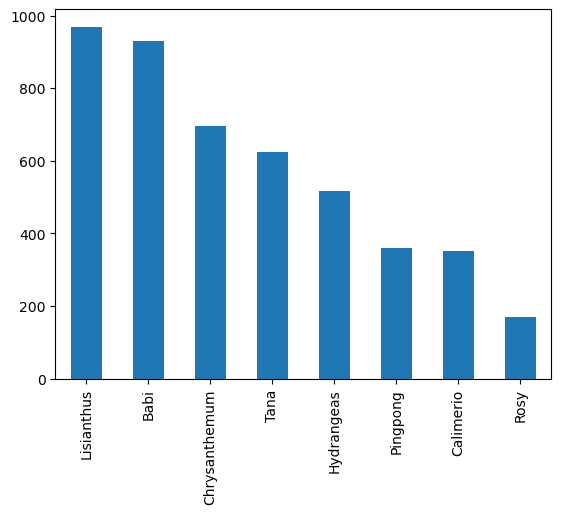

In [13]:
base_dataset['Flower_Types'].value_counts().plot.bar()

In [14]:
# So we can see that the data is imbalance so I decided to use other data source from outside

print(base_dataset['Flower_Types'].value_counts().to_frame())
print("\n")
print(base_dataset['Flower_Types'].value_counts(normalize=True).to_frame())

               Flower_Types
Lisianthus              969
Babi                    931
Chrysanthemum           696
Tana                    623
Hydrangeas              518
Pingpong                360
Calimerio               353
Rosy                    171


               Flower_Types
Lisianthus         0.209695
Babi               0.201472
Chrysanthemum      0.150617
Tana               0.134819
Hydrangeas         0.112097
Pingpong           0.077905
Calimerio          0.076390
Rosy               0.037005


### Data Preparation Part 2 (Handle Data From Outside and Combine with Base Dataset)


In [15]:
# This function returns the SHA-256 hash of a file.
def get_file_hash(filepath):
    
    sha256_hash = hashlib.sha256()
    with open(filepath, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()


# This function use to find duplicate images in dataset when combined
def find_duplicate_images(directory, other_directory):
    duplicates = {}
    hashes = set()

    # Traverse the first directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if the file is an image
            try:
                with Image.open(filepath) as img:
                    pass
            except:
                continue

            # Get the file size and hash
            file_size = os.path.getsize(filepath)
            file_hash = get_file_hash(filepath)

            # Check if the hash and size is already in the set
            if (file_hash, file_size) in hashes:
                if (file_hash, file_size) in duplicates:
                    duplicates[(file_hash, file_size)].append(filepath.replace('\\', '/'))
                else:
                    duplicates[(file_hash, file_size)] = [filepath.replace('\\', '/')]
            else:
                hashes.add((file_hash, file_size))

    # Traverse the other directory and its subdirectories
    for root, dirs, files in os.walk(other_directory):
        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if the file is an image
            try:
                with Image.open(filepath) as img:
                    pass
            except:
                continue

            # Get the file size and hash
            file_size = os.path.getsize(filepath)
            file_hash = get_file_hash(filepath)

            # Check if the hash and size is already in the set
            if (file_hash, file_size) in hashes:
                if (file_hash, file_size) in duplicates:
                    duplicates[(file_hash, file_size)].append(filepath.replace('\\', '/'))
                else:
                    duplicates[(file_hash, file_size)] = [filepath.replace('\\', '/')]

    # Group the duplicate images by their hash values and return the list of lists
    groups = []
    for group in duplicates.values():
        if len(group) > 1:
            groups.append(group)
    return groups

In [16]:
# It will be same to previous data preparation

# get additional data of flower types
additional_dir = './Dataset/FlowersAdded/'
additional_data_categories = [f.name for f in os.scandir(additional_dir) if f.is_dir()]
print(additional_data_categories)

additional_data_categories_number = len(additional_data_categories)
print("Number of flower categories: " + str(additional_data_categories_number))


additional_image_path=[]
additional_flower=[]

for category in additional_data_categories:
    dir_link_2 = additional_dir + category + "/"
    for img_path_2 in os.listdir(dir_link_2):
        additional_image_path.append(dir_link_2 + img_path_2)
        additional_flower.append(category)


# Set up flower image categories and combine to get dataframe
Image_path_2 = pd.Series(additional_image_path, name="Image_Path").astype(str)
Flowers_2=pd.Series(additional_flower, name="Flower_Types")
additional_dataset=pd.concat([Image_path_2, Flowers_2], axis=1)


['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']
Number of flower categories: 8


<AxesSubplot:>

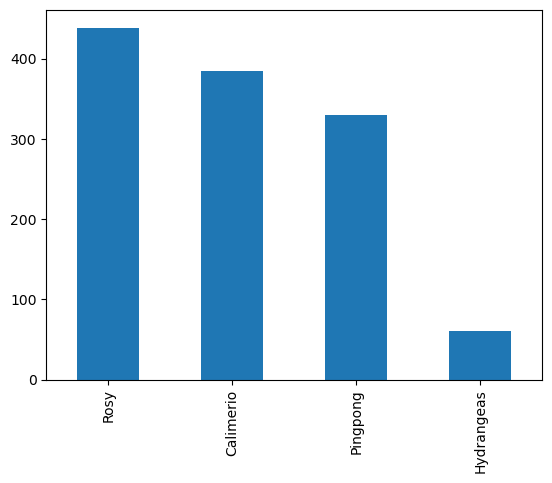

In [17]:
additional_dataset['Flower_Types'].value_counts().plot.bar()

In [18]:
# Reset index of items in 2 dataset and combine
base_dataset = base_dataset.reset_index(drop=True)
additional_dataset = additional_dataset.reset_index(drop=True)

combined_df = pd.concat([base_dataset, additional_dataset], ignore_index=True)

combined_df


,Image_Path,Flower_Types
0,./Dataset/Flowers/Chrysanthemum/chrysanthemum_...,Chrysanthemum
1,./Dataset/Flowers/Hydrangeas/hydrangeas_516.jpg,Hydrangeas
2,./Dataset/Flowers/Lisianthus/lisianthus_215.jpg,Lisianthus
3,./Dataset/Flowers/Tana/tana_381.jpg,Tana
4,./Dataset/Flowers/Lisianthus/lisianthus_512.jpg,Lisianthus
...,...,...
5830,./Dataset/FlowersAdded/Rosy/rosy_95.jpg,Rosy
5831,./Dataset/FlowersAdded/Rosy/rosy_96.jpg,Rosy
5832,./Dataset/FlowersAdded/Rosy/rosy_97.jpg,Rosy
5833,./Dataset/FlowersAdded/Rosy/rosy_98.jpg,Rosy


               Flower_Types
Lisianthus              969
Babi                    931
Calimerio               738
Chrysanthemum           696
Pingpong                690
Tana                    623
Rosy                    610
Hydrangeas              578


               Flower_Types
Lisianthus         0.166067
Babi               0.159554
Calimerio          0.126478
Chrysanthemum      0.119280
Pingpong           0.118252
Tana               0.106769
Rosy               0.104542
Hydrangeas         0.099057


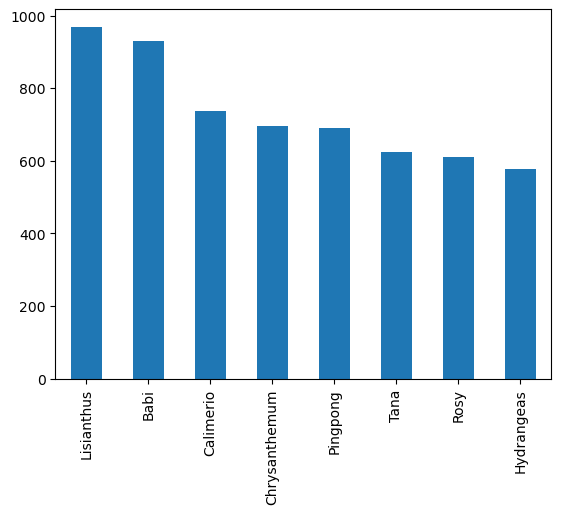

In [19]:
# Ok it solve a bit of imbalance dataset

combined_df['Flower_Types'].value_counts().plot.bar()

print(combined_df['Flower_Types'].value_counts().to_frame())
print("\n")
print(combined_df['Flower_Types'].value_counts(normalize=True).to_frame())

In [20]:
# Track which images are duplicated
duplicates_images = find_duplicate_images(base_dir, additional_dir)

duplicated_result = [item for sublist in duplicates_images[:] for item in sublist[1:]]
print("Amount of duplicated images: " + str(len(duplicated_result)))

# Remove in combined dataset not in real dataset
combined_df = combined_df[~combined_df['Image_Path'].isin(duplicated_result)]

# Reset index of combined dataframe 
combined_df.reset_index(drop=True, inplace=True)

# Check if the size of combined dataset is decrease after removed
combined_df.shape

Amount of duplicated images: 34


(5801, 2)

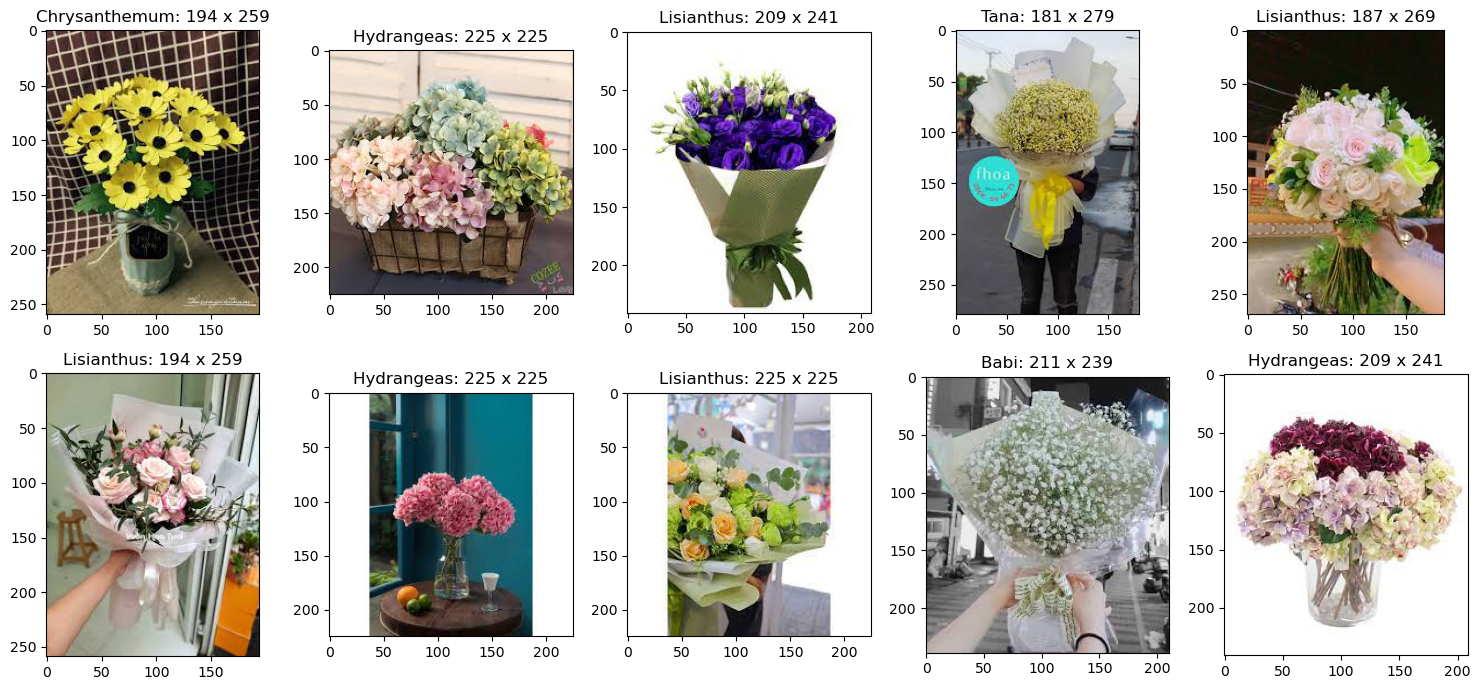

In [21]:
# Check image for image overview (contain name and size of flower images)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(combined_df.loc[i, "Image_Path"])
    ax.imshow(image_overview)
    
    width, height = image_overview.size
    ax.set_title(combined_df.loc[i, "Flower_Types"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

C:\Users\ASUS\Desktop\University\I.T\Year 1\Machine Learning\Assignment\2\ImageTesting\babi_flower.jpg is a .jpg file


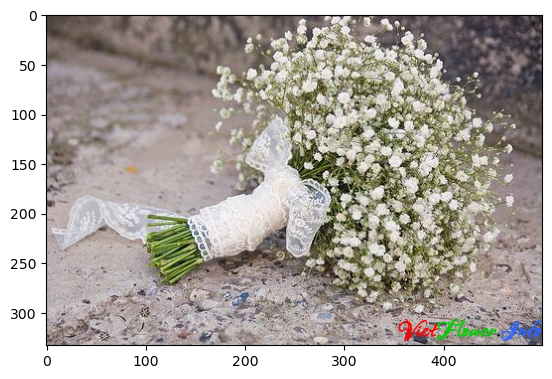

In [22]:
input_image_path = input("Please Input Your Image Location: ")
input_image_path.replace('\\', '/')

# Get the file extension from the file path
file_ext = os.path.splitext(input_image_path)[1]

# Check if the file extension is ".jpg"
if file_ext.lower() == ".jpg":
    correct_image_path = input_image_path
    plt.imshow(Image.open(input_image_path))
    print(f"{input_image_path} is a .jpg file")
else:
    print(f"{input_image_path} is not a .jpg file")

In [23]:
#defined
BATCH_SIZE = 32
IMG_WIDTH  = 224
IMG_HEIGHT = 224

def prepare(filepath):
    img_array = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    new_array = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
    return np.expand_dims(new_array, axis=0).repeat(BATCH_SIZE, axis=0)

# Predict input flower image
prediction = model.predict_classes(prepare(correct_image_path))

# Get type of flower data with in the same from user flower input and reset index after getting all items
types_predict_dataset = combined_df[combined_df['Flower_Types'] == dataset_categories[prediction[0]]]['Image_Path']
types_predict_dataset.reset_index(inplace=True, drop=True)


# Load the input flower image and convert it to a 1D Numpy array
input_image = Image.open(correct_image_path).convert('RGB')
input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
input_vector = np.array(input_image).ravel().reshape(1,-1)

# Load the dataset of flower images, resize them to the same size as the input image, and convert them to 1D Numpy arrays
dataset = []
for path in types_predict_dataset:
    img = Image.open(path).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT)) # Use the same size as the input image
    img_array = np.array(img).ravel()
    dataset.append(img_array)

dataset_vectors = np.array(dataset)

# Calculate the Cosine Similarity between the input vector and all dataset vectors
similarity_scores = cosine_similarity(input_vector, dataset_vectors)


List of 10 recommended type of flower images: 
./Dataset/Flowers/Tana/tana_301.jpg
./Dataset/Flowers/Tana/tana_393.jpg
./Dataset/Flowers/Tana/tana_288.jpg
./Dataset/Flowers/Tana/tana_53.jpg
./Dataset/Flowers/Tana/tana_348.jpg
./Dataset/Flowers/Tana/tana_492.jpg
./Dataset/Flowers/Tana/tana_495.jpg
./Dataset/Flowers/Tana/tana_261.jpg
./Dataset/Flowers/Tana/tana_436.jpg
./Dataset/Flowers/Tana/tana_311.jpg




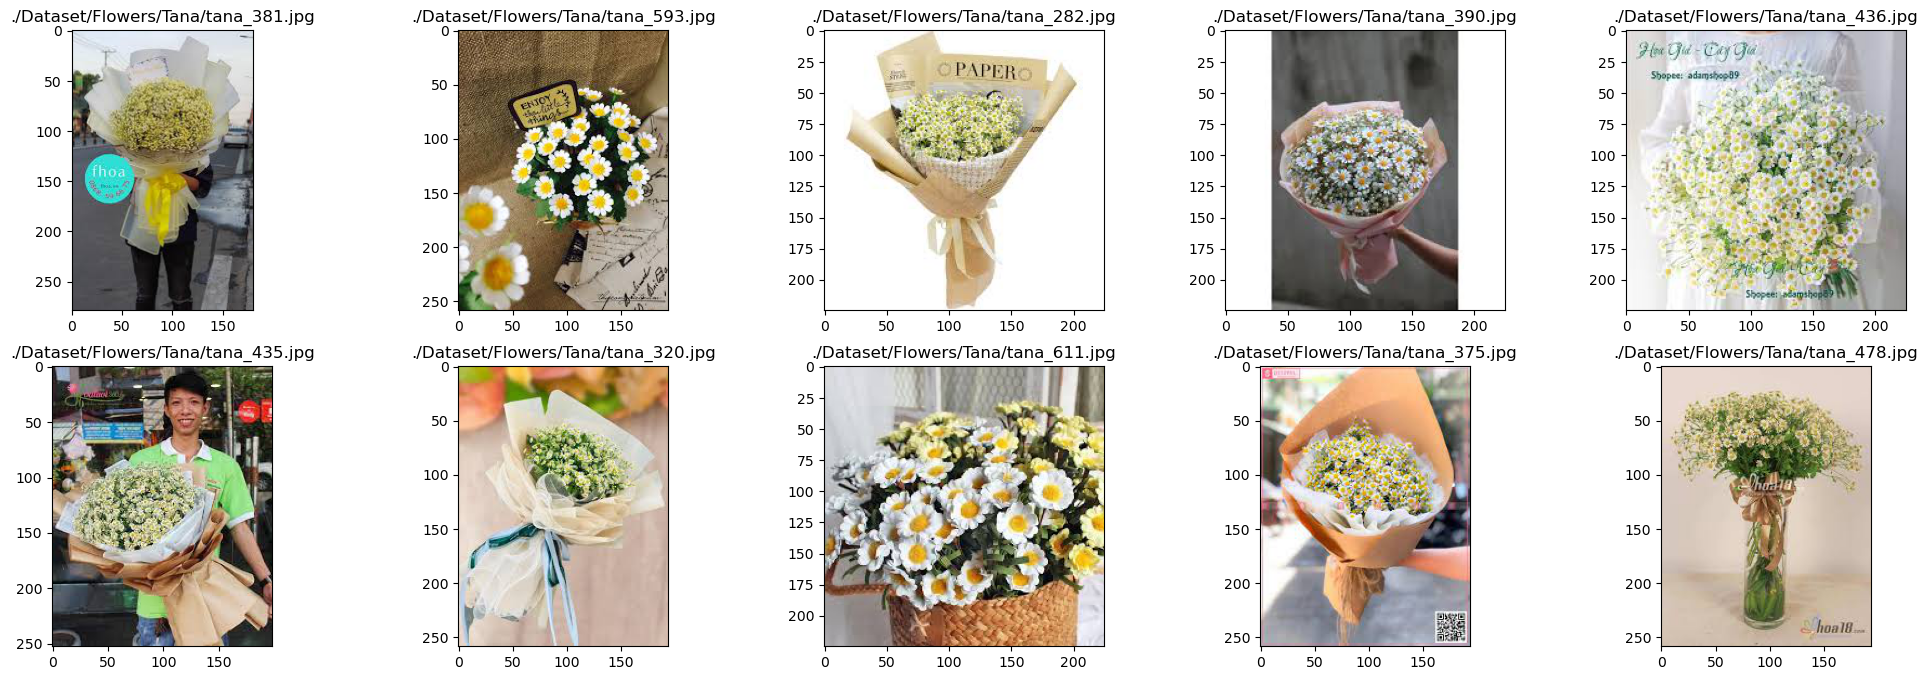

In [24]:
# Retrieve the indices of the top 10 most similar images
top_10_indices = similarity_scores.argsort()[0][-10:][::-1]

# Show the filenames of the top 10 most similar images and images also
print("List of 10 recommended type of flower images: ")
for i in top_10_indices:
    print(types_predict_dataset[i])
print('\n')


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25,8))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(types_predict_dataset[i]))
    ax.set_title(types_predict_dataset[i])
plt.show()